# Entity extraction on Financial Complaints with Watson NLP

This notebook demonstrates how to extract _named entities_ from financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Dictionary-based term extraction** with the _Rule-based extractor_ provided by `watson_nlp.resources.feature_extractor.RBR`. This allows you to train a custom extraction model based on given dictionaries.

- **Entity extraction** with the _Entity mentions block_ using the BERT model (`entity-mentions_bert_multi_stock`). This block extracts mentions of entities like *Persion*, *Organization* or *Duration* from the input text.


## Table of Contents

1.	[Before you start](#beforeYouStart)
2.	[Load the complaints](#loadData)
3.  [Custom term extraction using dictionaries](#dictionaries)
4.  [Entity extraction](#entities)
5.  [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [1]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [2]:
import watson_nlp

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [3]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [4]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/30/21,Debt collection,I do not know,Written notification about debt,Didn't receive notice of right to dispute,XXXX This should be deleted is because its not accurate. The DLA is an acronym for Date of Last Activity which translates to the last date you made a payment. ( you never did ) Under the Fair Credit Reporting Act everything on your credit report has to be accurate. \nBusinesses are not permitted to publish full credit card numbers on receipts. The law also allows you to protect your Social Sec...,None,"Castle Credit Co Holdings, LLC, Chicago, IL Branch",GA,30521,None,Consent provided,Web,04/02/21,Closed with explanation,Yes,NaN,4253389
1,03/17/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,There are numerous accounts listed on my credit report that I currently have no knowledge of. This was a result of mal practice or an error!,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,10524,None,Consent provided,Web,03/17/21,Closed with explanation,Yes,NaN,4220958
2,03/18/21,Debt collection,Auto debt,Written notification about debt,Didn't receive enough information to verify debt,I XXXX XXXX entered into a consumer credit transaction with XXXX XXXX XXXX on XX/XX/2017. A consumer credit transaction in which a finance charge was involved. 15 usc 1605 defines a finance charge as the sum of all charges in a consumer credit transaction. The finance does not include cash but XXXX XXXX XXXX took cash. The finance is suppose to include insurance but XXXX XXXX XXXX made me purc...,None,"CarMax, Inc.",CT,06511,None,Consent provided,Web,03/18/21,Closed with explanation,Yes,NaN,4226003


You can look at all products that are available in the data set to do further analysis around these product groups.

<AxesSubplot:>

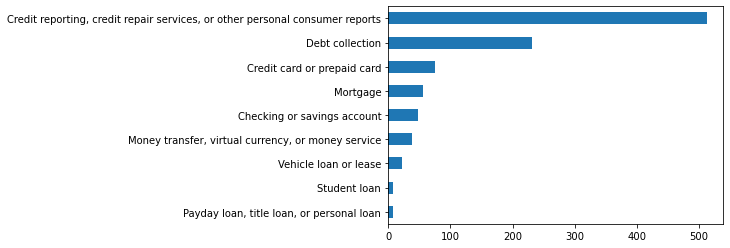

In [5]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate customers suspecting a fraud concerning their financial products like the theft of a credit card.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [6]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the fraud-related terms divided into *FRAUD* and *THEFT*. Each line has one dictionary entry.

In [7]:
fraud_file = "fraud_mappings.csv"
with open(os.path.join(RBR_dicts_folder, fraud_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"FRAUD\", \"fraud\"\n")
    dict.write("\"FRAUD\", \"takeover\"\n")
    dict.write("\"FRAUD\", \"skimming\"\n")
    dict.write("\"FRAUD\", \"phishing\"\n")
    dict.write("\"THEFT\", \"theft\"\n")
    dict.write("\"THEFT\", \"thief\"\n")
    dict.write("\"THEFT\", \"thieve\"\n")
    dict.write("\"THEFT\", \"steal\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match, for example, "steal" -> "stole", "stolen", "stealing".

In [8]:
dictionary = watson_nlp.toolkit.DictionaryConfig.load( 
    {
        'name': 'fraud_mappings',
        'source': fraud_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the unterlying AQL code.

In [9]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='en', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single complaint. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediatly, you will access the raw response from the underlying RBR executor.

In [10]:
def extract_dictionary(complaint_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(complaint_text, language='en')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the complaint text.

In [11]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Fraud Indicators'})
# combine with the complaint dataframe
text_dict_matches_df = df[["Product", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)
text_dict_matches_df.head(10)

,Product,Consumer complaint narrative,Fraud Indicators
0,Debt collection,XXXX This should be deleted is because its not accurate. The DLA is an acronym for Date of Last Activity which translates to the last date you made a payment. ( you never did ) Under the Fair Credit Reporting Act everything on your credit report has to be accurate. \nBusinesses are not permitted to publish full credit card numbers on receipts. The law also allows you to protect your Social Sec...,[]
1,"Credit reporting, credit repair services, or other personal consumer reports",There are numerous accounts listed on my credit report that I currently have no knowledge of. This was a result of mal practice or an error!,[]
2,Debt collection,I XXXX XXXX entered into a consumer credit transaction with XXXX XXXX XXXX on XX/XX/2017. A consumer credit transaction in which a finance charge was involved. 15 usc 1605 defines a finance charge as the sum of all charges in a consumer credit transaction. The finance does not include cash but XXXX XXXX XXXX took cash. The finance is suppose to include insurance but XXXX XXXX XXXX made me purc...,[]
3,Debt collection,I have a fraudulent account on my credit report that I have never heard of.,[]
4,"Payday loan, title loan, or personal loan","We have a Home Equity Line of Credit- which the bank now calls "" Personal Line of Credit '' even though the loan is attached to the house- and there is no line of credit anymore. There hasn't been for a couple years. We are both still on unemployment and have lost substantial income during this pandemic. I am in the process of starting my own XXXX XXXX XXXX and will be building it starting XX/...",[]
5,Debt collection,On XX/XX/2021 PORTFOLIO RECOVERY ASSOCIATES was contacted through certified mail regarding a corespondence of an attempt to collect a debt in the amount of XXXX ( partial account # XXXX ) The original creditor XXXX XXXX was also contacted by certified mail letter in regards to disputing alleged debt. Portfolio Recovery Associates as of todays date XX/XX/2021 has never responded to written core...,[]
6,"Credit reporting, credit repair services, or other personal consumer reports",My Department of Education/Navient are reporting me as 90 days late XX/XX/XXXX when I have made a payment and reporting me 150 days late XXXX and XXXX of XXXX when my account was in Forbearance also the report is missing data,[]
7,"Credit reporting, credit repair services, or other personal consumer reports",I demand the deletion of the fraudulent accounts and inquiries listed below which all resulted from the Reported Incident of Identity Theft. \n\nFRAUDULENT AND INACCURATE ACCOUNTS THAT SHOULD BE DELETED : 1. XXXX XXXX XXXX - Account # XXXX ( Reported Identity Theft ) - Fraudulently Opened on XX/XX/XXXX. \n2. XXXX XXXX XXXX XXXX XXXX - Account # XXXX ( Reported Identity Theft ) - Fraudulently O...,"[(THEFT, Theft), (THEFT, Theft), (THEFT, Theft), (THEFT, Theft), (THEFT, Theft), (THEFT, Theft), (THEFT, Theft), (THEFT, Theft), (THEFT, Theft), (THEFT, Theft)]"
8,Debt collection,"Client services, inc is a fraud. XXXX XXXX XXXX XXXX XXXX in XXXX XXXX mo They have my name and address. Sent me a letter saying I owe them {$2500.00}. They say they are debt collectors. This letter looks so real who knows how many people they have frauded by this! Reading their comments, this has happened to many people. Also, people who work there have commented as its a horrible place and t...","[(FRAUD, fraud)]"
9,"Credit reporting, credit repair services, or other personal consumer reports",I mailed a letter to the credit bureaus on XX/XX/2021 asking them to validate suspicious accounts i noticed on my credit report due to my identity being compromised. They have failed to even investigate or send me correspondence back indicating they did an investigation and what the out come was. I have no knowledge of these accounts XXXX XXXX XXXX XXXX XXXX XXXX XXXX Acct # XXXX ... XXXX Acct...,[]


Notice that "stolen" was detected as *THEFT* as the base-form *steal* is contained in the dictionary and you used lemma-matching.

How many complaints talk about *THEFT* or *FRAUD* or both? Count the complaints for each product group and display the relative frequency: 

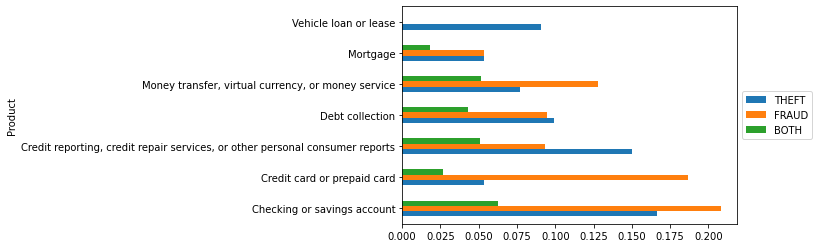

In [12]:
# create a column indicating if the complaint contains at least one *FRAUD* or *THEFT* match
text_dict_matches_df['THEFT'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'THEFT' in set([match[0] for match in matches]))
text_dict_matches_df['FRAUD'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]) and 'THEFT' in set([match[0] for match in matches]))

# get the relative frequency by product group
perc_theft = text_dict_matches_df.groupby('Product')['THEFT'].value_counts(normalize=True)
perc_fraud = text_dict_matches_df.groupby('Product')['FRAUD'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('Product')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_theft, perc_fraud, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('Product')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Nearly 20% of the credit or prepaid card complaints seem to deal with theft and over 25% of the checking or savings account complaints with fraud.

<a id="entities"></a>
## Entity extraction

The complaints contain a lot of entity mentions about entities like organizations, money, durations, etc. In this section you will learn how to use the BERT entity mention extraction block, which extracts entity mentions out-of-the-box. 

The BERT entity mention model depends on the syntax model. Start with loading both models:

In [13]:
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
bert_entity_model = watson_nlp.load(watson_nlp.download('entity-mentions_bert_multi_stock'))

The helper method first runs the syntax model and then the entity extraction model on top of the syntax result:

In [14]:
def extract_entities(complaint_text):
    # run syntax model
    syntax_result = syntax_model.run(complaint_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the entity mention model on the result of the syntax model
    entity_mentions = bert_entity_model.run(syntax_result)
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the complaint dataframe and show the extracted entities along with the complaint text. **Note:** This cell will run for several minutes.

In [ ]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})
# combine with our complaint dataframe
text_entities_df = df[["Product", text_col]].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head()

Let's see what kind of entities are extracted from the complaints:

In [ ]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create separate rows for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by product:

In [ ]:
unstacked = exp_entities.groupby('Product')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Job Titles* are frequently mentioned in the *Vechicle loan or lease* product group and there is a high number of *Location* mentions for the product group *Debt collection*. Let's look at some sample texts for the job titles:

In [ ]:
exp_entities.query('`Entity Type` == "JobTitle" and Product == "Vehicle loan or lease"').head()

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained model for entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.